In [1]:
import lammps
import pymc3 as pm
import arviz as az
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from lammps_data import LammpsData
from pymatgen.io.vasp import Poscar

In [2]:
def init(lammps_data, structure, cs_springs=None):
    """
    Initialises the system from the structure (read in from lammps input) and non-changing parameters.
    
    Args:
        structure (str): Name of lammps input file.
        cs_springs (optional:dict): A dictionary of the bond_coeff values. Key = atom label and values = K
                                    (energy/distance^2) and r0 (equilibrium bond distance) (list).
                                    Default = None.
        lammps_data (obj): LammpsData stuctural object containing information on atom_types, bond_types,
                           atoms, bonds, cell_lengths, and tilt_factors.

    Returns:
        lmp (Lammps): Lammps system with structure and specified commands implemented.
    """
    
    lmp = lammps.Lammps(units='metal', style = 'full', args=['-log', 'none', '-screen', 'none'])
    lmp.command('read_data {}'.format(structure))

    lmp.command('group cores type {}'.format(lammps_data.type_core()))
    lmp.command('group shells type {}'.format(lammps_data.type_shell()))

    if cs_springs:
        lmp.command('pair_style buck/coul/long/cs 10.0')
        lmp.command('pair_coeff * * 0 1 0')

        lmp.command('bond_style harmonic')
        for i, spring in enumerate(cs_springs):
            lmp.command('bond_coeff {} {} {}'.format(i+1,
                                                     cs_springs[spring][0],
                                                     cs_springs[spring][1]))
    else:
        lmp.command('pair_style buck/coul/long 10.0')
        lmp.command('pair_coeff * * 0 1 0')
    
    lmp.command('kspace_style ewald 1e-6')
        
    #setup for minimization
    lmp.command('min_style cg')

    return lmp

In [3]:
def update_potentials(**kwargs):
    """
    Unpdates the potentials set by pymc3 into the dictionary for the fitting process.

    Args:
        **kwargs: The parameters to be updated in the fitting process as set with pm.Model.

    Returns:
        None.
    """
#     for key, value in kwargs.items():
#         my_dict.update({key: value})
    for key, value in kwargs.items():    
        for pot in lammps_data.potentials:
            if key is pot.a.label_string:
                pot.a.value = value
            if key is pot.rho.label_string:
                pot.rho.value = value
            if key is pot.c.label_string:
                pot.c.value = value
#     [print(pot.a.value) for pot in lammps_data.potentials]
    
def set_potentials(instance):
    """
    Sets the potential for the sepecified Lammps system (changes for each iteration of the potential fit).

    Args:
        instance (Lammps): Lammps system with structure and specified commands implemented.

    Returns:
        None
    """
    for pot in lammps_data.potentials:
        instance.command('{}'.format(pot.potential_string()))
#         print('{}'.format(pot.potential_string()))
                         

In [4]:
def simfunc(**kwargs):
    """
    Runs a minimization and zero step run for the instance and returns the forces.

    Args:
        **kwargs: Contain data for type of fitting and to what parameters as set with pm.Model.

    Returns:
        out (np.array): x,y,z forces on each atom.
    """
    if min(kwargs.values()) > 0:
        update_potentials(**kwargs)
        out = np.zeros([sum(core_mask),3])
        
        set_potentials(instances)

        instances.command('fix 1 cores setforce 0.0 0.0 0.0')
        instances.command('minimize 1e-25 1e-25 5000 10000')
        instances.command('unfix 1')
        instances.run(0)
        
        out = instances.system.forces[core_mask]
            
    else:
        out = np.ones([sum(core_mask),3])*999999999 # ThisAlgorithmBecomingSkynetCost

    return out

In [5]:
params = {}
params['core_shell'] = { 'Li': False, 'Ni': False, 'O': True }
params['charges'] = {'Li': +1.0,
                     'Ni': +3.0,
                     'O': {'core':  +0.960,
                           'shell': -2.960}}
params['masses'] = {'Li': 6.941,
                    'Ni': 58.6934,
                    'O': {'core': 15.0,
                          'shell': 1.0} }

params['bpp'] = {'Li-O' : [632.1018, 0.2906, 0.0],
                 'Ni-O' : [1582.5000, 0.2882, 0.0],
                 'O-O'  : [22764.3000, 0.1490, 21.7]}

params['sd'] = {'Li-O' : [50, 0.05, 0.01],
                'Ni-O' : [100, 0.05, 0.05],
                'O-O'  : [100, 0.01, 5]}

#Must be in same order given in charges dictionary
cs_springs = {'O' : [65.0, 0.0]} #Set to None if not using any core-shells

bpp_def = deepcopy(params['bpp'])

poscar = Poscar.from_file('POSCAR1')
my_structure = poscar.structure
lammps_data = LammpsData.from_structure(my_structure, params)
lammps_file = 'coords.lmp'
with open( lammps_file, 'w' ) as f:
    f.write(lammps_data.input_string())

Found elements: ['Li', 'Ni', 'O']


In [6]:
instances = init(lammps_data, lammps_file, cs_springs)
core_mask = lammps_data.core_mask()

In [7]:
excude_from_fit = ['Li_O_c','Ni_O_c']

In [8]:
expected = np.zeros([sum(core_mask),3])

In [9]:
with pm.Model() as model:
#  pm.TruncatedNormal -- truncated so never tries a negative    pm.Uniform
    my_dict = {}
    for pot in lammps_data.potentials:
        name = '{}'.format(pot.a.label_string)
        if name not in excude_from_fit:
            my_dict[name] = pot.a.distribution()
        name = '{}'.format(pot.rho.label_string)
        if name not in excude_from_fit:
            my_dict[name] = pot.rho.distribution()
        name = '{}'.format(pot.c.label_string)
        if name not in excude_from_fit:
            my_dict[name] = pot.c.distribution()
        
    simulator = pm.Simulator('simulator', simfunc, observed=expected)
    
    trace = pm.sample(step=pm.SMC(ABC=True, epsilon=0.1), draws=1000)
#     trace = pm.sample(step=pm.SMC(ABC=True, epsilon=3000, dist_func="sum_of_squared_distance"), parallel=False, draws=1000)

Sample initial stage: ...
/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pymc3/step_methods/smc.py:176: UserWarning: Warning: SMC-ABC methods are experimental step methods and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Stage: 0 Beta: 0.004 Steps: 25
Stage: 1 Beta: 0.022 Steps: 25
Stage: 2 Beta: 0.108 Steps: 3
Stage: 3 Beta: 0.268 Steps: 9
Stage: 4 Beta: 0.616 Steps: 25
Stage: 5 Beta: 1.000 Steps: 6


/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


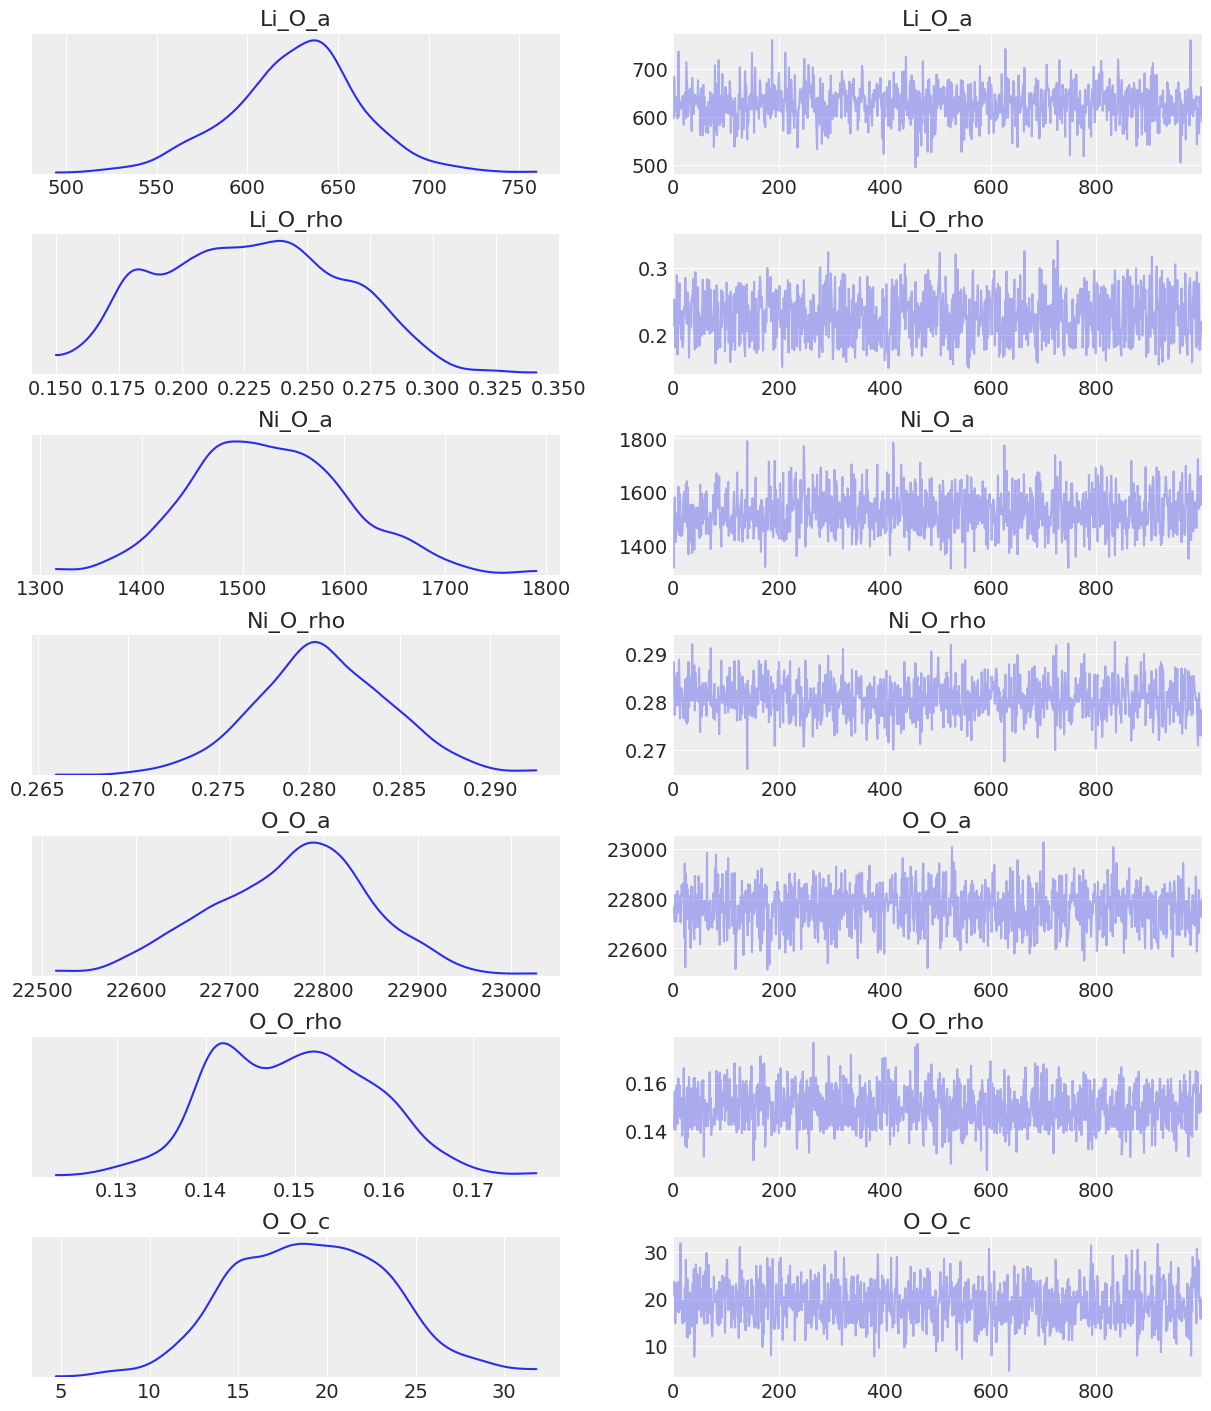

In [10]:
az.style.use('arviz-darkgrid')
az.plot_trace(trace)
plt.savefig('coreshell_LiNiO2_trace2.png',dpi=500, bbox_inches = "tight")

/Users/lmm82/.pyenv/versions/3.7.3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


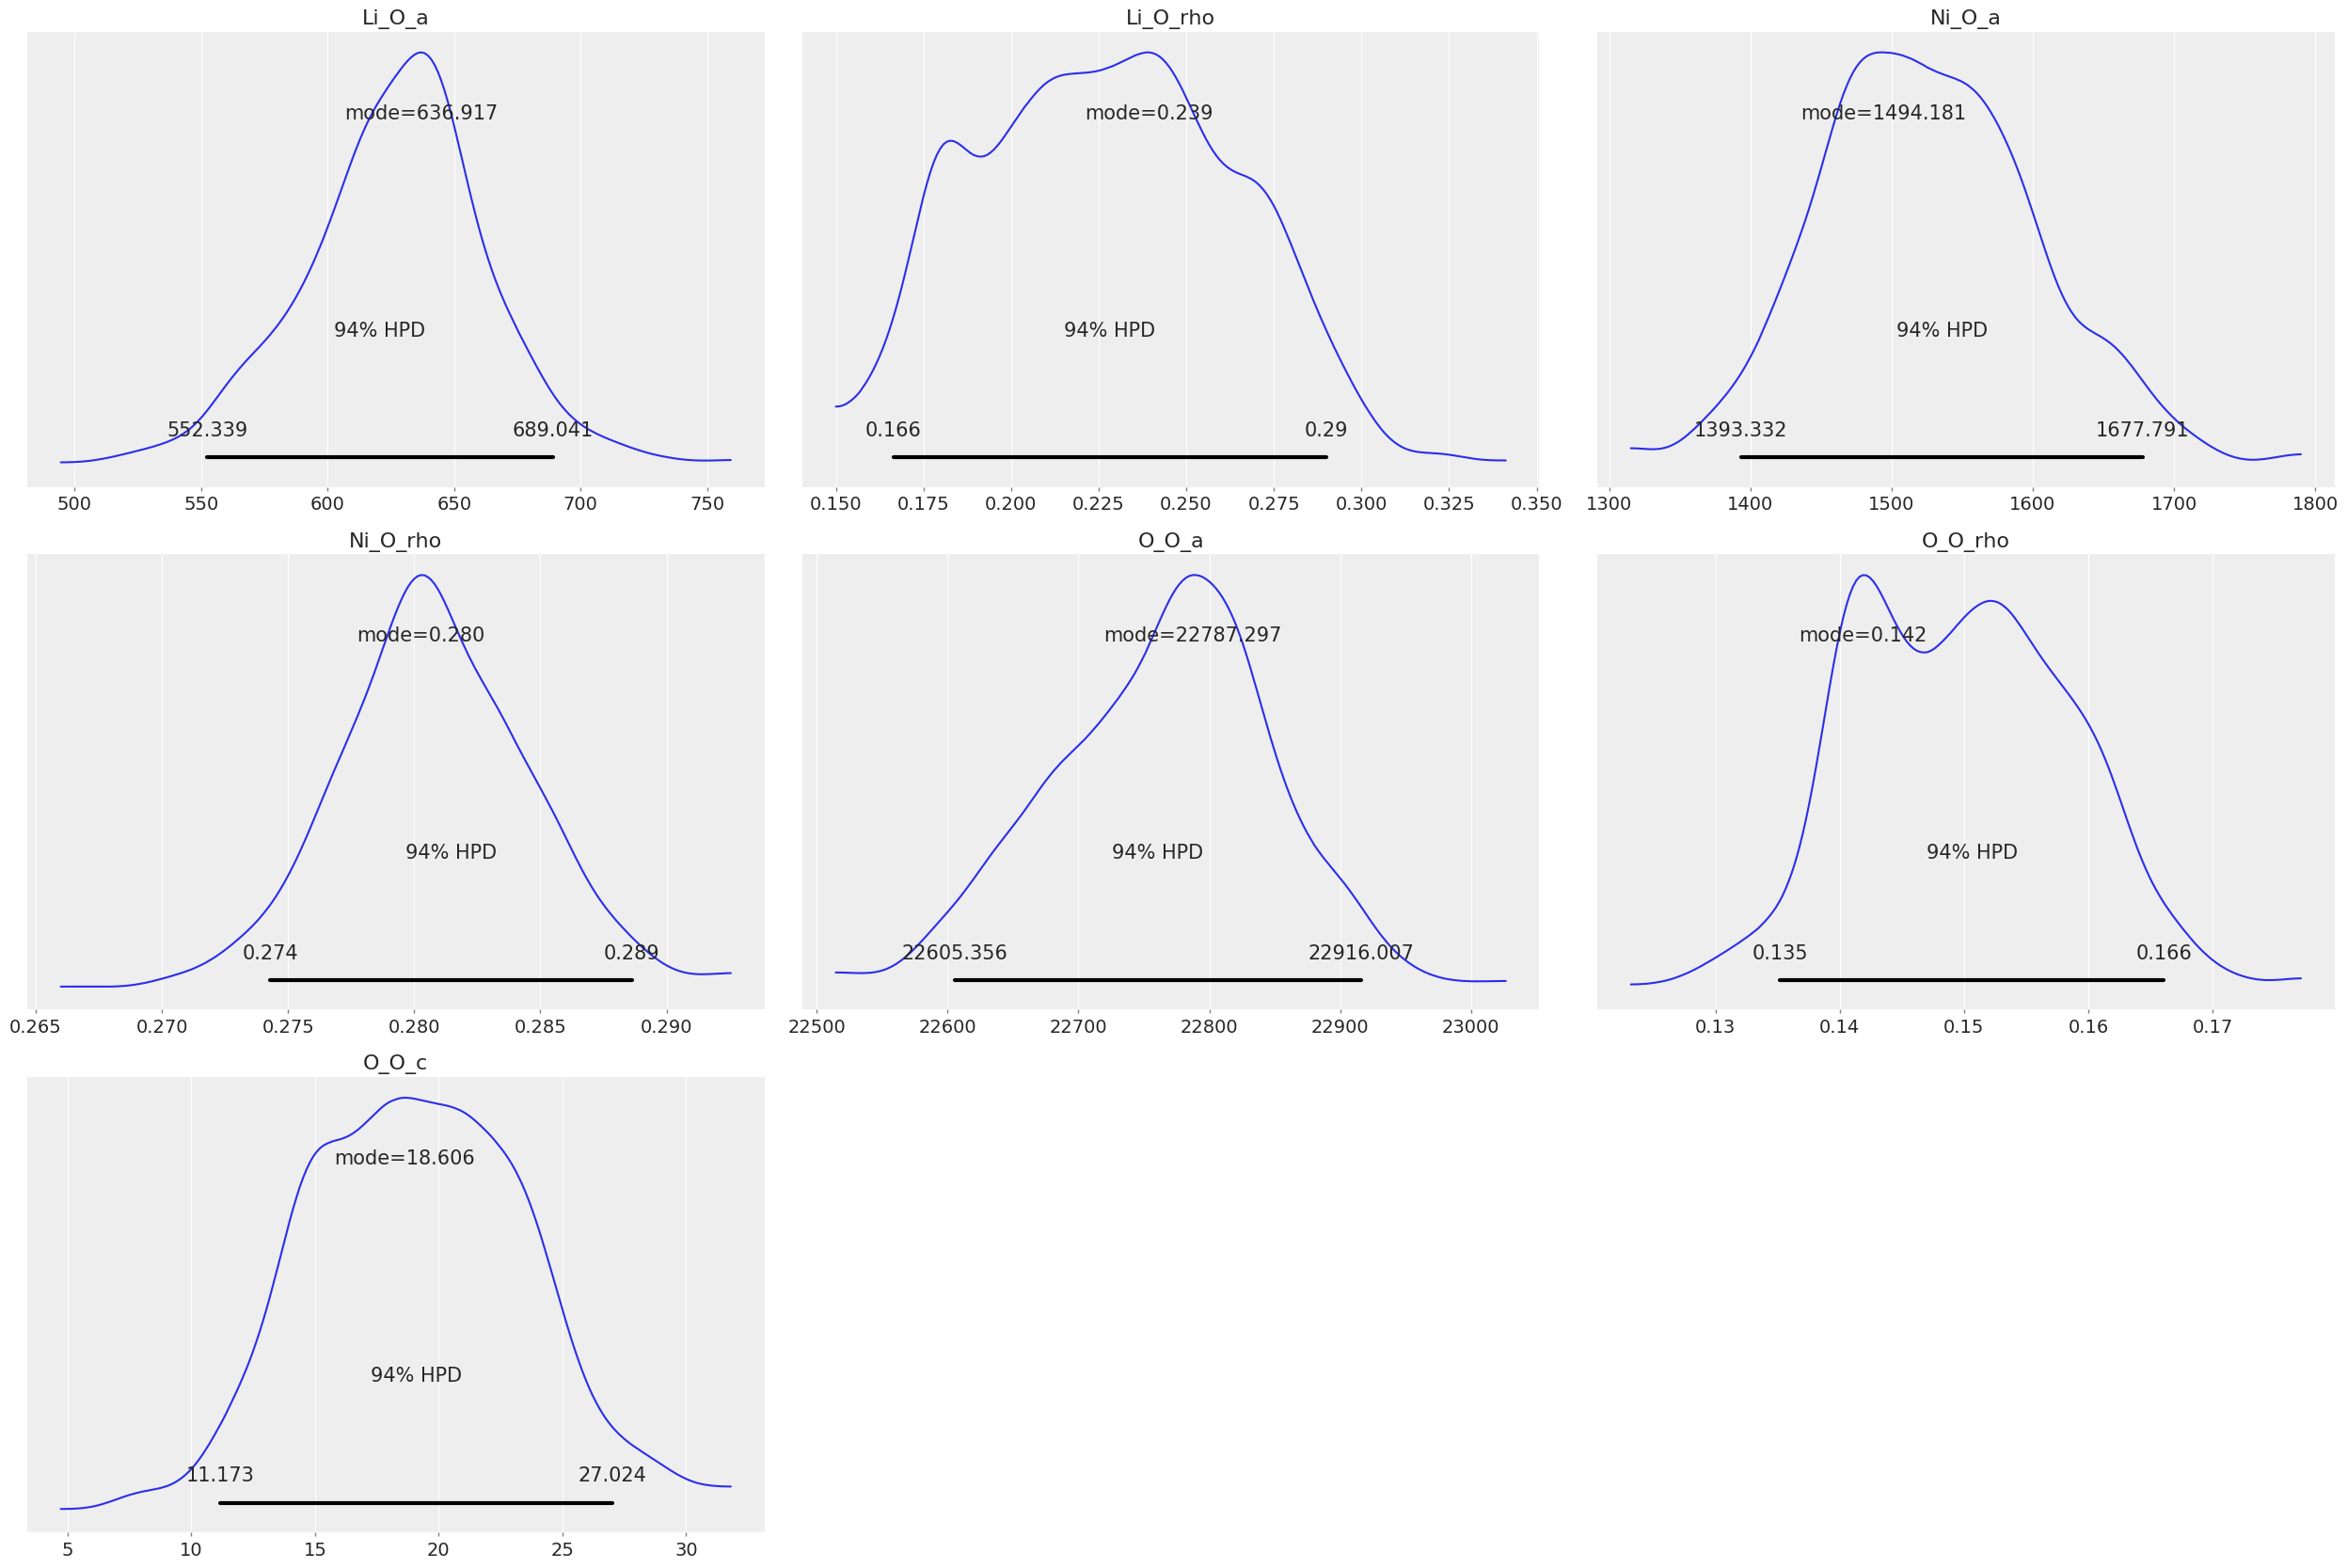

In [11]:
az.plot_posterior(trace, round_to = 3, point_estimate = 'mode')
plt.savefig('coreshell_LiNiO2_mode2.png',dpi=500, bbox_inches = "tight")